In [1]:
from itertools import product

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import rotate

from src.models.layers import CHConv2D, ECHConv2D


In [2]:
def tri(x):
    return np.where(np.abs(x) <= 1, np.where(x < 0, x + 1, 1 - x), 0)


def get_atoms(kernel_size=3, max_degree=5, normalize=True):
    radius = (kernel_size - 1) // 2
    x_grid = np.arange(-radius, radius + 1, 1)
    x, y = np.meshgrid(x_grid, x_grid)
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    atoms = np.zeros(
        (
            kernel_size,
            kernel_size,
            max_degree + 1,
            kernel_size // 2 + 1,
        ),
        dtype=np.csingle,
    )
    for i, n in product(range(kernel_size // 2 + 1), range(max_degree + 1)):
        # atoms[:, :, 0, 0, n, i] = (np.exp(-0.5 * ((r - i) / sigma)**2) *
        #                            np.exp(theta * n * 1j))
        atoms[:, :, n, i] = (tri(r - i) * np.exp(theta * n * (1j)))
    atoms[kernel_size // 2, kernel_size // 2, :, :] = 0
    if normalize:
        norm = np.sqrt(np.sum(np.conj(atoms) * atoms, axis=(0, 1)))
        norm[norm == 0] = 1
        atoms = atoms / norm

    return atoms


def compute_spectrum(f, kernel_size=3, max_degree=5):
    atoms = get_atoms(kernel_size=kernel_size,
                      max_degree=max_degree,
                      normalize=True)
    atoms = np.sum(atoms, axis=-1)
    # norm = np.sqrt(np.sum(np.conj(atoms) * atoms, axis=(0, 1)))
    # norm[norm == 0] = 1
    # atoms = atoms / norm
    spectrum = np.zeros((max_degree + 1))
    for n in range(max_degree + 1):
        ch_proj = np.sum(f * np.conj(atoms[..., n]))
        spectrum[n] = np.sqrt(np.abs(ch_proj * np.conj(ch_proj)))
    return spectrum


In [3]:
max_degree = 5
kernel_size = 9
shs = get_atoms(kernel_size=kernel_size, max_degree=max_degree)
shs = np.sum(shs, axis=-1)
# shs = get_chs(kernel_size=kernel_size, degrees=max_degree)

In [4]:
dot_prod = np.sum((shs[:, :, 1]) * np.conj(shs[:, :,4]))
np.abs(dot_prod)


5.9604645e-08

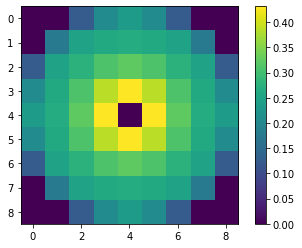

In [5]:
plt.imshow(np.abs(shs[...,0]))
plt.colorbar()

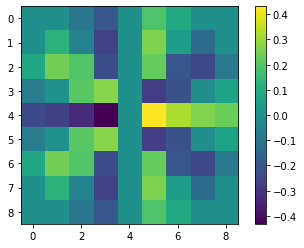

In [6]:
plt.imshow(np.real(shs[...,5]))
plt.colorbar()

In [9]:
factor = np.zeros((max_degree + 1, ))
factor[1] = 1
factor[3] = 0
factor[5] = 0
factor = factor[np.newaxis, np.newaxis, :]

phi = np.pi * 0.25
rotation_factor = np.exp(1j * np.arange(max_degree + 1) * phi)


In [10]:
f = np.real(np.sum(shs * factor, axis=-1))
f_rotated = np.real(np.sum(shs * factor * rotation_factor, axis=-1))

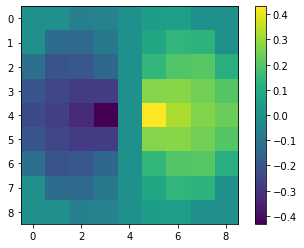

In [11]:
plt.imshow(f)
plt.colorbar()

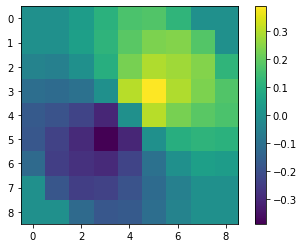

In [12]:
plt.imshow(f_rotated)
plt.colorbar()

In [13]:
layer = ECHConv2D(1,
                 kernel_size,
                 max_degree=max_degree,
                 initializer=tf.keras.initializers.Constant(1.0))


In [14]:
x = f[np.newaxis, :, :, np.newaxis]
y = np.squeeze(layer(x).numpy())


In [15]:
y.shape

(6,)

In [16]:
np.abs(y)

array([4.6566129e-10, 2.4998870e+00, 7.4511625e-08, 1.9323997e-01,
       1.9446587e-08, 1.9324008e-01], dtype=float32)

In [17]:
compute_spectrum(f, kernel_size=kernel_size, max_degree=max_degree)

array([0.00000000e+00, 1.09658817e+00, 0.00000000e+00, 6.48214102e-02,
       8.32667268e-17, 6.48214118e-02])

In [ ]:
filters = layer.filters.numpy()
plt.imshow(np.real(filters[:, :, 0, 0, 1]))
plt.colorbar()

In [ ]:
plt.imshow(np.real(filters[:, :, 0, 0, 1]))
plt.colorbar()

In [ ]:
atoms = np.squeeze(layer.atoms.numpy())
plt.imshow(np.real(np.sum(atoms, axis=-1)[:, :, 0]))
plt.colorbar()

In [ ]:
np.squeeze(y)